In [1]:
#imports
import logging
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression
import matplotlib.pyplot as plt
from river_models import *

from river import stream,linear_model,preprocessing, ensemble, metrics, optim
from river.neighbors import KNNRegressor 
from sklearn.metrics import mean_squared_error
from river.utils import dict2numpy, numpy2dict



seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and output directories

#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["db_id","sample_id"] #
output_cols = None
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/6.02_v3") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\5.02_v2\PLN7


In [3]:
data = pd.read_csv(data_file)
data=data.sample(frac=1,random_state=random_state)

pre_ind =[i for i in range(0,10000)]
pretrain_ind,pretest_ind = train_test_split(pre_ind,train_size=5/6,random_state=random_state,shuffle=False)
stream_ind = [i for i in range(10000,110000)]

pretrain_data =  ut.TabularDataset(data.iloc[pretrain_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
pretest_data = ut.TabularDataset(data.iloc[pretest_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
stream_data = ut.TabularDataset(data.iloc[stream_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

nrow, ncol = data.shape
nrow_train = len(pretrain_data)
nrow_test = len(pretest_data)
nrow_stream = len(stream_data)

print(f"train: {nrow_train}, test: {nrow_test}, stream: {nrow_stream}")

train: 8333, test: 1667, stream: 100000


In [4]:
#setup evaluation
from river.neighbors import KNNRegressor

def setup_models():
    lin0 =  SlidingWindowLR(ridge=False)
    lin1 =  (preprocessing.StandardScaler() | SlidingWindowLR(ridge=False))
    lin2 =  SlidingWindowLR(ridge=True)
    lin3 =  (preprocessing.StandardScaler() | SlidingWindowLR(ridge=True))
    knn1 =  KNNRegressor(n_neighbors= 500)
    knn2 =  (preprocessing.StandardScaler() |KNNRegressor(n_neighbors= 500))
    lwr1 =  StreamLocalWeightedRegression(n_neighbors= 500, window_size=10000,floor=True)
    lwr2 =  (preprocessing.StandardScaler() |StreamLocalWeightedRegression(n_neighbors= 500, window_size=10000,floor=True))
    
    return {'lin0':lin0,
            'lin1':lin1,
            'lin2':lin2,
            'lin3':lin3,
            'lwr1':lwr1,
            'lwr2':lwr2,
            'knn1':knn1,
            'knn2':knn2

           }
            #,'lin1':lin1,
            #'lin2':lin2,
            #'lin3':lin3
            #'lwr1':(preprocessing.StandardScaler()|StreamLocalWeightedRegression(n_neighbors= 500, window_size=10000))
            #'lwr2':(preprocessing.StandardScaler()|StreamLocalWeightedRegression(n_neighbors= 800, window_size=10000)),
           # 'lwr3':(preprocessing.StandardScaler()|StreamLocalWeightedRegression(n_neighbors= 1000, window_size=10000))
           



In [5]:
#setup our metrics and stores of results
river_models = setup_models()
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling': {name:RollingR2(window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:RollingMSE(window_size=1000) for name in full_set}
          }
    


In [6]:
#so sofar we have establish our metrics and scores are correct
from tqdm.notebook import tqdm, trange

In [7]:
#take our pretrained models, now evaluate them on 

In [8]:
_,_,river_models,metrics = prequential_evaluate(pretrain_data,river_models,metrics,pretrain = len(pretrain_data),num_its=len(pretrain_data))

  0%|          | 0/8333 [00:00<?, ?it/s]

In [9]:
preds_test,scores_test,metrics = score_evaluate(pretest_data,river_models,metrics,num_its=len(pretest_data))

  0%|          | 0/1667 [00:00<?, ?it/s]

In [11]:
preds_stream, scores_stream,river_models,metrics = prequential_evaluate(stream_data,river_models,metrics,pretrain=0,num_its=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
def zip_dict(dict1,dict2):

    dict12 = {k:dict1[k]+dict2[k] for k in dict1.keys()}   
    return dict12

def zip_nested_dict(dict1,dict2):
    dict12 = {}
    
    for k in dict1.keys():
        dict12[k] = {name:dict1[k][name]+dict2[k][name] for name in dict1[k].keys()}
    return dict12

In [13]:
preds = zip_dict(preds_test,preds_stream)

In [14]:
scores = zip_nested_dict(scores_test,scores_stream)

In [15]:
preds_df = pd.DataFrame(preds)
preds_df.to_csv(log_dir/"preds_df.csv")


In [16]:
#findings
#1) preprocessing works, random lr things for lr don't
#) standardisation asks as regularisation

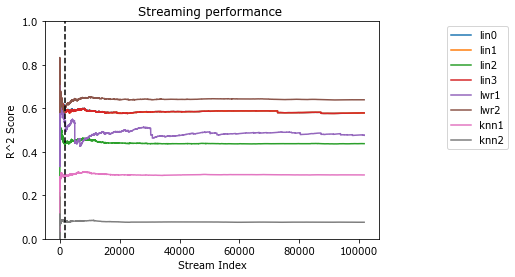

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['R2'])
scores_df.to_csv(log_dir/"r2_scores.csv")
for (columnName, columnData) in scores_df.iteritems():

    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2.png",bbox_inches='tight')


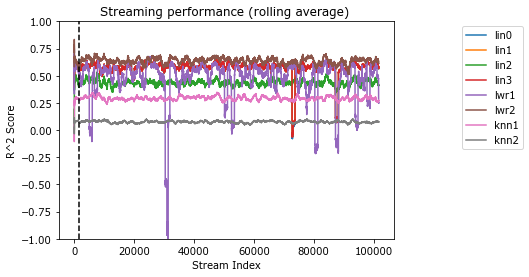

In [18]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance (rolling average) ")
    
scores_df = pd.DataFrame(scores['R2_rolling'])
scores_df.to_csv(log_dir/"r2_scores_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    columnData
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(-1,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2.png",bbox_inches='tight')

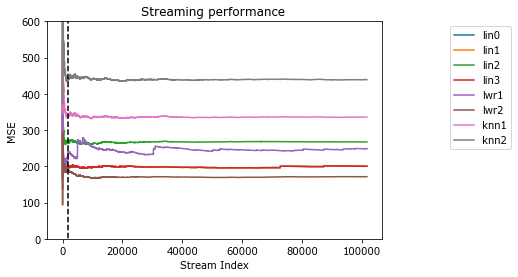

In [19]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['MSE'])
scores_df.to_csv(log_dir/"MSE.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1000,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')
ax.set_ylim(0,600)
plt.savefig(log_dir / f"mse_plot_v2.png",bbox_inches='tight')

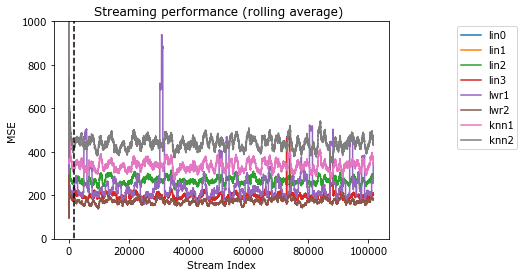

In [20]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance (rolling average) ")

scores_df = pd.DataFrame(scores['MSE_rolling'])
scores_df.to_csv(log_dir/"MSE_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1000,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(-1,1000)
plt.savefig(log_dir / f"mse_plot_rolling_v2.png",bbox_inches='tight')

lin0, p = 0.7614385645040659, MSE = 200.20399359692482, R2 = 0.5788342363468522
lin1, p = 0.7614891477746273, MSE = 200.14496133386115, R2 = 0.5789584215227155
lin2, p = 0.661819889942799, MSE = 267.35406420892997, R2 = 0.437571765701
lin3, p = 0.761482631242086, MSE = 200.14918278898372, R2 = 0.578949540918795
lwr1, p = 0.7346423689444559, MSE = 249.20963923048495, R2 = 0.4757418864103774
lwr2, p = 0.8068905481731036, MSE = 171.43069583447314, R2 = 0.6393641374103667
knn1, p = 0.6064907410559873, MSE = 335.75136384373974, R2 = 0.2936855204020935
knn2, p = 0.394978499429971, MSE = 439.1521181517768, R2 = 0.07616309805654409


(0.0, 500.0)

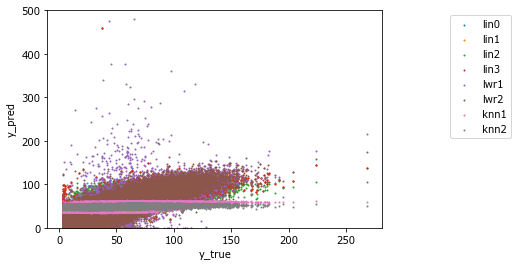

In [21]:
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

fig, ax = plt.subplots()
ax.set_ylabel('y_pred')
ax.set_xlabel('y_true')

for (columnName, columnData) in preds_df.iteritems():
        if not columnName == 'y':
            ax.scatter(preds_df['y'],columnData,label = f"{columnName}",s=1)
            
            corr_coef = scipy.stats.pearsonr(columnData, preds_df['y'])
            r2 = r2_score(preds_df['y'],columnData)
            #slope, intercept, r, p, stderr = scipy.stats.linregress(columnData, preds_df['y'])
            loss = mean_squared_error(preds_df['y'], columnData)
            mae = mean_absolute_error(preds_df['y'], columnData)    
            print(f"{columnName}, p = {corr_coef[0]}, MSE = {loss}, R2 = {r2}")
            
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylim(0,500)